# Hate Intensity Prediction (HIP): Regression

HIP Module takes a sentence (whether normalised or not) and predicts the hateful intensity of the sentence.

The hate intensity is annotated on a scale of 1-10, 0 is reserved for non-hateful sentences which we do not use in our dataset.
1 is the lowest hate intensity and 10 is the highest.

If using final activation layer is linear then range stays same.
If using sigmoid activation layer then input label is normalised to 0-1 range.


In [1]:
import tensorflow as tf
from tqdm import tqdm
import numpy as np
from transformers import BertTokenizer
from transformers import DistilBertTokenizer, RobertaTokenizer, BertConfig, TFBertModel
from sklearn.model_selection import train_test_split
import pickle
import random
import sys
import math
from scipy import stats
from scipy.spatial import distance
import random
import os

C:\ProgramData\anaconda3\envs\research\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# Limit GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs


In [15]:
BASE_FOLDER = "data/"
INPUT_FILE = "hate_norm_combined.pkl"
OUTPUT_FOLDER = "output_weights/"
OUTPUT_FILE = "output_weights"
BERT_MODEL = "distilbert-base-uncased"

MAX_LENGTH = 128
TEST_SIZE = 0.2
SEED = 42

USE_ATT = True

BERT_DROPOUT = 0.2
LSTM_UNITS = 50
DENSE_UNITS = 50
LSTM_DROPOUT = 0.1
DENSE_DROPOUT = 0.2
EPOCHS = 10 #(Default 10)
BATCH_SIZE = 32

def random_seed(SEED):
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

random_seed(SEED)

### Base TRANSFORMER MODEL definitions

In [4]:
def tokenize(sentences, tokenizer):
    input_ids, input_masks, input_segments = [], [], []
    for sentence in tqdm(sentences):
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=MAX_LENGTH,
                                       pad_to_max_length=True, return_attention_mask=True, return_token_type_ids=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])

    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32'), np.asarray(input_segments, dtype='int32')


## Define base bert configs
config = BertConfig(dropout=BERT_DROPOUT, attention_dropout=BERT_DROPOUT, output_attentions=True)
config.output_hidden_states = False

transformer_model = TFBertModel.from_pretrained(BERT_MODEL, config=config)
for layer in transformer_model.layers[:3]:  ## Freeze first 3 layers
    layer.trainable = False

# Defining tokonizer
tokenizer = DistilBertTokenizer.from_pretrained(BERT_MODEL, do_lower_case=True, add_special_tokens=True, max_length=MAX_LENGTH, pad_to_max_length=True)

C:\ProgramData\anaconda3\envs\research\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['distilbert.transformer.layer.2.attention.q_lin.bias', 'distilbert.transformer.layer.0.ffn.lin1.weight', 'distilbert.transformer.layer.0.output_layer_norm.weight', 'vocab_transform.bias', 'distilbert.transformer.layer.0.ffn.lin2.weight', 'distilbert.transformer.layer.4.ffn.lin1.weight', 'distilbert.transformer.layer.4.ffn.lin2.weight', 'distilbert.transformer.layer.0.output_layer_norm.bias', 'distilbert.transformer.layer.5.attention.v_lin.bias', 'distilbert.transformer.layer.1.attention.k_lin.bias', 'distilbert.transformer.layer.5.attention.k_lin.bias', 'distilbert.transformer.layer.0.ffn.lin1.b

### Model Design

In [5]:
input_ids_in = tf.keras.layers.Input(shape=(MAX_LENGTH, ), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(MAX_LENGTH, ), name='masked_token', dtype='int32')

embedding_layer = transformer_model(input_ids_in, attention_mask=input_masks_in)[0]

X = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(LSTM_UNITS, return_sequences=True,
                         dropout=LSTM_DROPOUT, recurrent_dropout=LSTM_DROPOUT, kernel_initializer='normal')
    )(embedding_layer)

if USE_ATT:
    X = tf.keras.layers.Attention(use_scale=True)([X, X])  # Use attention.
    
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(DENSE_UNITS, activation='relu',  kernel_initializer='normal')(X)
X = tf.keras.layers.Dropout(DENSE_DROPOUT)(X)
X = tf.keras.layers.Dense(1, activation='linear', kernel_initializer='normal')(X)

model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs=X)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['acc', tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_token[0][0]',            
                                thPoolingAndCrossAt               'masked_token[0][0]']           
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

### Dataset prep

In [6]:
with open(BASE_FOLDER + INPUT_FILE, 'rb') as f:
    input_data = pickle.load(f)

intensity_value = []
hate_sentences = []

for i in range(len(input_data)):
    intensity_value.append(int(input_data['Original_Intensity'][i]))
    hate_sentences.append(input_data['Sentence'][i])
    intensity_value.append(int(input_data['Normalized_Intensity'][i]))
    hate_sentences.append(input_data['Normalized_Sentence'][i])

c = list(zip(intensity_value, hate_sentences))
random.shuffle(c)
intensity_value, hate_sentences = zip(*c)

X_tr, X_te, y_tr, y_te = train_test_split(hate_sentences, intensity_value, test_size=TEST_SIZE, random_state=1)

train_input_ids, train_input_masks, train_input_segment = tokenize(X_tr, tokenizer)
test_input_ids, test_input_masks, test_input_segment = tokenize(X_te, tokenizer)

y_tr = np.asarray(y_tr)
y_te = np.asarray(y_te)

  0%|                                                                                         | 0/4843 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\ProgramData\anaconda3\envs\research\lib\site-packages\transformers\tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (

In [7]:
# print(X_tr) # Training sentences
print("Train input ids: \n", train_input_ids, 
      "\n\nAttention masks: \n", train_input_masks, 
      "\n\nToken type ids: \n", train_input_segment) # input_ids, attention_masks, token_type_ids

Train input ids: 
 [[  101  2026 11190 ...     0     0     0]
 [  101  1030  5310 ...     0     0     0]
 [  101  2074  2043 ...     0     0     0]
 ...
 [  101  2589 15966 ...     0     0     0]
 [  101 14015  1041 ...     0     0     0]
 [  101  2317  2450 ...     0     0     0]] 

Attention masks: 
 [[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]] 

Token type ids: 
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


### Train and evlauate

Below is the training of the model. The RMSE for training was 1.6530 and testing was 1.6529.

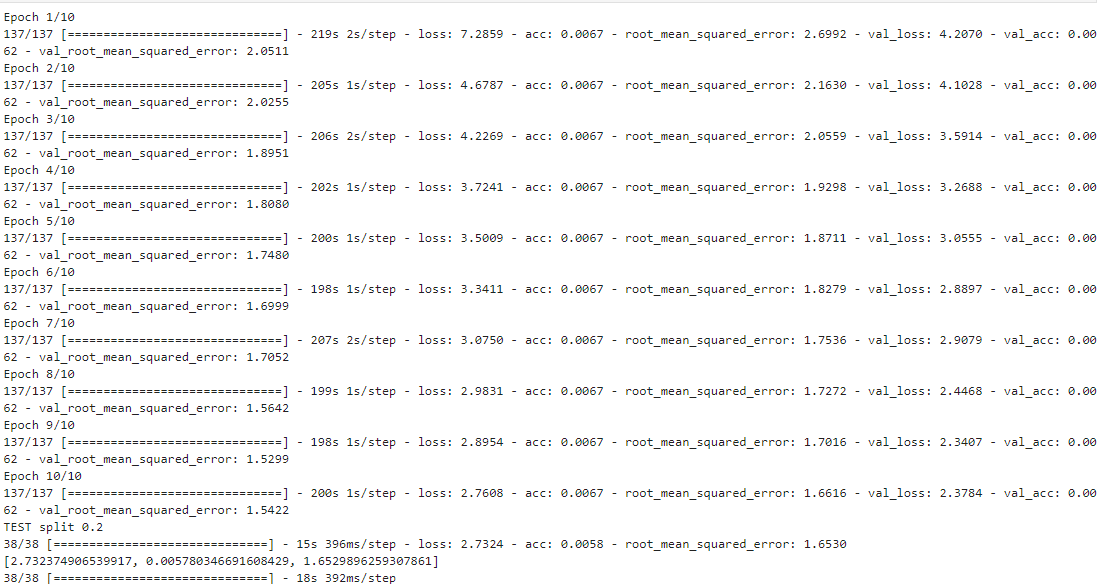

In [8]:
model.fit(x=[train_input_ids, train_input_masks], y=y_tr, epochs=EPOCHS, validation_split=0.1, batch_size=BATCH_SIZE)

Epoch 1/10
137/137 [==============================] - 219s 2s/step - loss: 7.2859 - acc: 0.0067 - root_mean_squared_error: 2.6992 - val_loss: 4.2070 - val_acc: 0.0062 - val_root_mean_squared_error: 2.0511
Epoch 2/10
137/137 [==============================] - 205s 1s/step - loss: 4.6787 - acc: 0.0067 - root_mean_squared_error: 2.1630 - val_loss: 4.1028 - val_acc: 0.0062 - val_root_mean_squared_error: 2.0255
Epoch 3/10
137/137 [==============================] - 206s 2s/step - loss: 4.2269 - acc: 0.0067 - root_mean_squared_error: 2.0559 - val_loss: 3.5914 - val_acc: 0.0062 - val_root_mean_squared_error: 1.8951
Epoch 4/10
137/137 [==============================] - 202s 1s/step - loss: 3.7241 - acc: 0.0067 - root_mean_squared_error: 1.9298 - val_loss: 3.2688 - val_acc: 0.0062 - val_root_mean_squared_error: 1.8080
Epoch 5/10
137/137 [==============================] - 200s 1s/step - loss: 3.5009 - acc: 0.0067 - root_mean_squared_error: 1.8711 - val_loss: 3.0555 - val_acc: 0.0062 - val_root_me

AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [ ]:
results = model.evaluate(x=[test_input_ids, test_input_masks], y=y_te)

In [10]:
print(results)

result = model.predict(x=[test_input_ids, test_input_masks])
result = np.array(result, dtype=np.float64)
result = result.flatten()

[2.732374906539917, 0.005780346691608429, 1.6529896259307861]
38/38 [==============================] - 16s 406ms/step


In [13]:
_, _, rmse = results
print("RMSE", rmse)
print("Pearson", stats.pearsonr(result, y_te))
print("Cosine", 1 - distance.cosine(result, y_te))

RMSE 1.6529896259307861
Pearson PearsonRResult(statistic=0.6458429122585165, pvalue=7.010217723179573e-144)
Cosine 0.9638204514506321


### To save model

In [16]:
# model.save_weights(BASE_FOLDER + OUTPUT_FOLDER + OUTPUT_FILE)

### To load model
Run upto the cells up till `model_design` part and then do

In [ ]:
# model.load_weights(BASE_FOLDER+OUTPUT_FOLDER+OUTPUT_FILE)